# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/bia?postal=22903&search_distance=100#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [4]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [10]:
import re # Regular expressions

brands = ['giant', 'trek', 'gt', 'ridley', 'electra', 'scwinn', 'mongoose',
          'diamondback', 'quintana', 'serotta', 'raleigh', 'velo', 'hercules',
          'scattante', 'fuji']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [11]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(321, 6)


,title,price,year,link,brand,age
0,giant ocr--27 spd-700c-sti flight deck shift/b...,475,NaN,https://washingtondc.craigslist.org/nva/bik/d/...,giant,NaN
1,"trek 4900, 22.5"" frame, 24 speed, recently tuned",395,NaN,https://washingtondc.craigslist.org/nva/bik/d/...,trek,NaN
2,2023 gt stomper pro--disc brakes-small adult f...,350,2023.0,https://washingtondc.craigslist.org/nva/bik/d/...,gt,2.0
3,"trek xcaliber 6 mountain bike hybrid - 19.5"" f...",325,NaN,https://washingtondc.craigslist.org/nva/bik/d/...,trek,NaN
4,custom built ridley,1170,NaN,https://lynchburg.craigslist.org/bik/d/lynchbu...,ridley,NaN


With the data in and wrangled, we can now do EDA:

count     321.000000
mean      452.186916
std       747.528199
min         0.000000
25%        80.000000
50%       200.000000
75%       400.000000
max      5000.000000
Name: price, dtype: float64


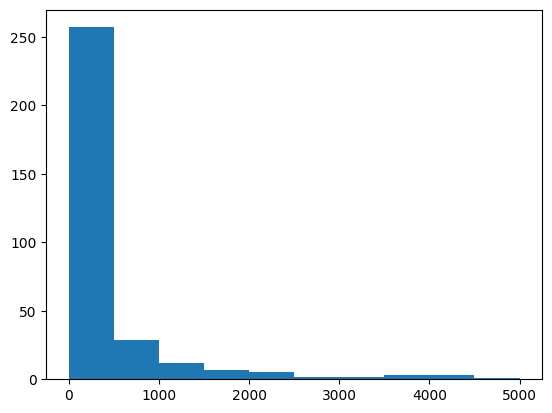

count     21.000000
mean      33.666667
std       28.832852
min        2.000000
25%        4.000000
50%       32.000000
75%       40.000000
max      125.000000
Name: age, dtype: float64


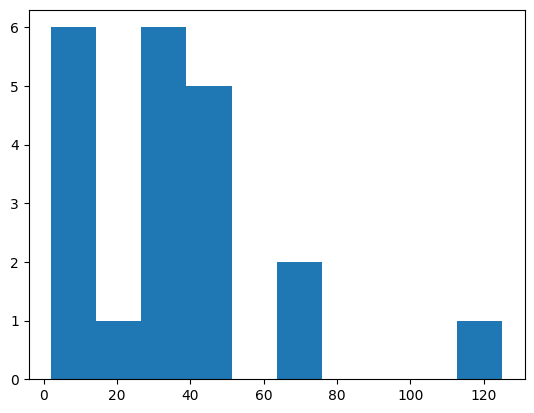

In [12]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [13]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
             count        mean          std    min     25%    50%      75%   
brand                                                                        
diamondback    9.0  292.777778   424.552052   20.0   90.00  200.0   250.00   
electra        1.0  350.000000          NaN  350.0  350.00  350.0   350.00   
fuji          13.0  282.692308   104.594761  100.0  220.00  275.0   375.00   
giant         19.0  688.157895  1096.426279  140.0  170.00  300.0   485.00   
gt            10.0  319.800000   266.005764   60.0  154.75  300.0   368.75   
hercules       1.0   35.000000          NaN   35.0   35.00   35.0    35.00   
missing      201.0  446.442786   804.105091    0.0   60.00  150.0   400.00   
mongoose       8.0  204.375000   291.687669   20.0   30.00  127.5   175.00   
quintana       3.0  995.000000     0.000000  995.0  995.00  995.0   995.00   
raleigh        9.0  195.444444   154.904899  100.0  125.00  150.0   180.00   
ridley         2.0  865.000000   431.335137  560.0  712.50  865.0  1017.50   
scattante      5.0  334.000000    76.925288  250.0  250.00  380.0   395.00   
serotta        1.0  899.000000          NaN  899.0  899.00  899.0   899.00   
trek          37.0  580.351351   731.352295   20.0  150.00  300.0   395.00   
velo           2.0  149.000000     0.000000  149.0  149.00  149.0   149.00   

                     
                max  
brand                
diamondback  1400.0  
electra       350.0  
fuji          400.0  
giant        4000.0  
gt            999.0  
hercules       35.0  
missing      5000.0  
mongoose      900.0  
quintana      995.0  
raleigh       600.0  
ridley       1170.0  
scattante     395.0  
serotta       899.0  
trek         2600.0  
velo          149.0

In [14]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                
            count  mean        std   min   25%   50%   75%    max
brand                                                            
diamondback   0.0   NaN        NaN   NaN   NaN   NaN   NaN    NaN
electra       0.0   NaN        NaN   NaN   NaN   NaN   NaN    NaN
fuji          0.0   NaN        NaN   NaN   NaN   NaN   NaN    NaN
giant         2.0   4.0   0.000000   4.0   4.0   4.0   4.0    4.0
gt            2.0   2.0   0.000000   2.0   2.0   2.0   2.0    2.0
hercules      0.0   NaN        NaN   NaN   NaN   NaN   NaN    NaN
missing      11.0  39.0  33.349663   3.0  26.5  32.0  39.5  125.0
mongoose      1.0  40.0        NaN  40.0  40.0  40.0  40.0   40.0
quintana      0.0   NaN        NaN   NaN   NaN   NaN   NaN    NaN
raleigh       3.0  53.0  10.583005  45.0  47.0  49.0  57.0   65.0
ridley        0.0   NaN        NaN   NaN   NaN   NaN   NaN    NaN
scattante     0.0   NaN        NaN   NaN   NaN   NaN   NaN    NaN
serotta       1.0  29.0        NaN  29.0  29.0  29.0  29.0   29.0
trek          1.0  38.0        NaN  38.0  38.0  38.0  38.0   38.0
velo          0.0   NaN        NaN   NaN   NaN   NaN   NaN    NaN

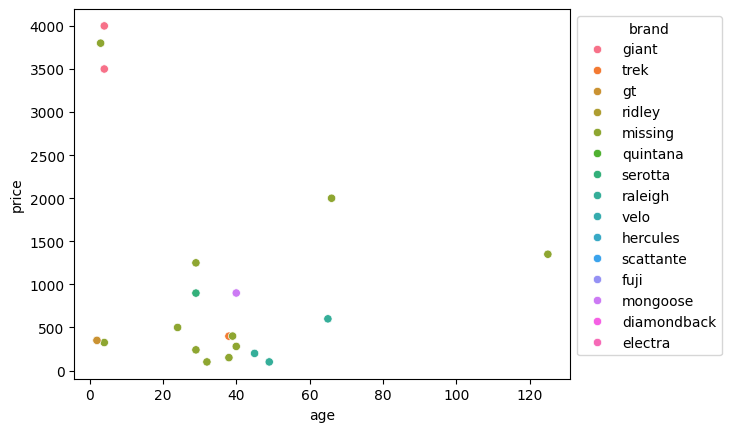

In [15]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   1.806578 -0.399228
log_age    -0.399228  1.625092
           log_price  log_age
log_price    1.00000 -0.27843
log_age     -0.27843  1.00000


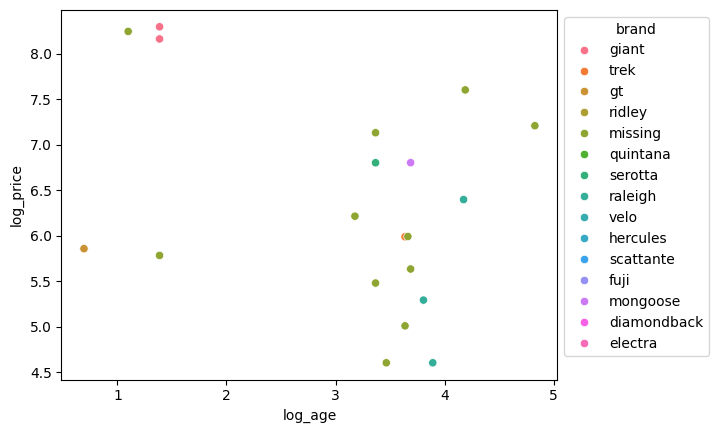

In [16]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

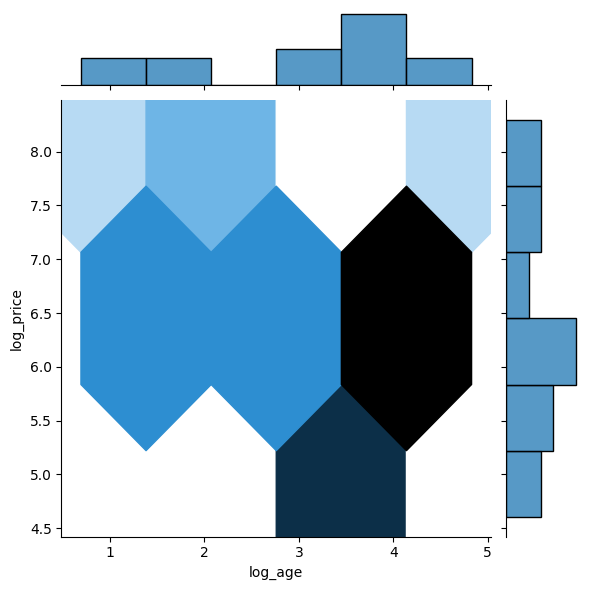

In [17]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')